In [1]:
%matplotlib inline
import numpy as np
import math
import random
import pyJHTDB
import time as tt
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import filters
import skimage.morphology as morphology
from skimage.morphology import square
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from matplotlib import cm

# load shared library
lTDB = pyJHTDB.libJHTDB()
#initialize webservices
lTDB.initialize()

#Add token
auth_token  = "edu.jhu.pha.turbulence.testing-201311"  #Replace with your own token here
lTDB.add_token(auth_token)

dataset = 'transition_bl'

spatialInterp  = 0  # no spatial interpolation
temporalInterp = 0  # no time interpolation
FD4NoInt       = 40 # 4th-order FD, no spatial interpolation

# Database domain size and number of grid points
x_min =   30.2185
x_max = 1000.0650
y_min =    0.0036
y_max =   26.4880
z_min =    0.0000
z_max =  240.0000
d99i  =    0.9648
d99f  =   15.0433

nx = 3320
ny =  224
nz = 2048

# Database time duration
Ti = 0
Tf = Ti + 1175
dt = 0.25


In [2]:
# Create surface
nix = round(nx / 4)
niz = round(nz / 4)
x = np.linspace(x_min, x_max, nix)
z = np.linspace(z_min, z_max, niz)
y = d99i

[X,Z] = np.meshgrid(x,z)
points = np.zeros((nix,niz,3))
points[:,:,0] = X.transpose()
points[:,:,1] = y
points[:,:,2] = Z.transpose()

# 2D array with single precision values
points = np.array(points,dtype='float32')


In [3]:
# Get the velocity at each point

time = Ti

start = tt.time()
print('Requesting velocity at {0} points...'.format(nix*niz))
result = lTDB.getData(time, points, data_set = 'transition_bl',
        sinterp = spatialInterp, tinterp = temporalInterp,
        getFunction = 'getVelocity')
end = tt.time()
print('   '+str(end - start)+' seconds')

start = tt.time()
print('Requesting velocity gradients at {0} points...'.format(nix*niz))
result_grad = lTDB.getData(time, points, data_set = 'transition_bl',
        sinterp = FD4NoInt, tinterp = temporalInterp,
        getFunction = 'getVelocityGradient')
end = tt.time()
print('   '+str(end - start)+' seconds')

Requesting velocity at 424960 points...
   74.00687599182129 seconds
Requesting velocity gradients at 424960 points...
   156.71080803871155 seconds


Plot U contour

Text(0.5, 1.0, '$u$')

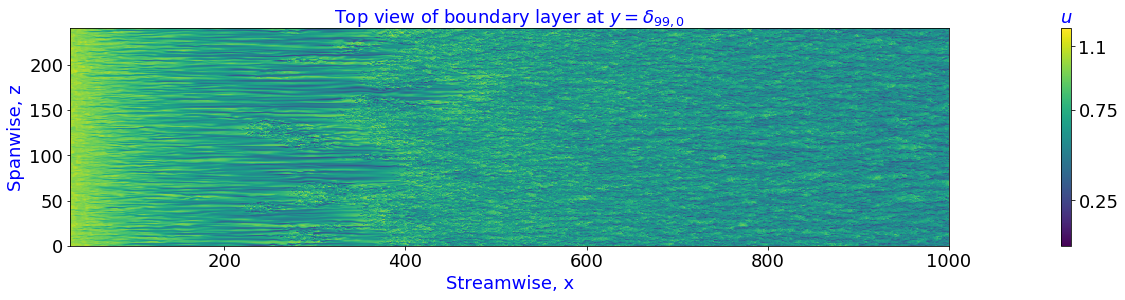

In [4]:
fig = plt.figure(figsize = (40,4))
ax = fig.add_subplot(111)

ax.set_title('Top view of boundary layer at $ y = \delta_{99,0}$', fontsize=18, color='blue')
ax.set_xlabel('Streamwise, x', fontsize=18, color='blue')
ax.set_ylabel('Spanwise, z', fontsize=18, color='blue')
ax.tick_params(axis='both', which='major', labelsize=18)

cax = ax.imshow(result[:,:,0].transpose(),
               extent = [x_min, x_max, z_min, z_max],
               interpolation = 'none',
               vmin=0, vmax=1.2,
               cmap=cm.viridis)    # default colormap 'viridis', 'plasma', 'inferno', 'magma'

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[0.25, 0.75, 1.1], orientation='vertical')  # Horizontal/vertical  colorbar
cbar.ax.set_yticklabels(['0.25', '0.75', '1.1'])  
cbar.ax.tick_params(axis='both', which='major', labelsize=18)
cbar.ax.set_title('$u$', fontsize=18, color='blue') 


Plot |v'|+|w'| contour

Text(0.5, 1.0, "$|v'|+|w'|$")

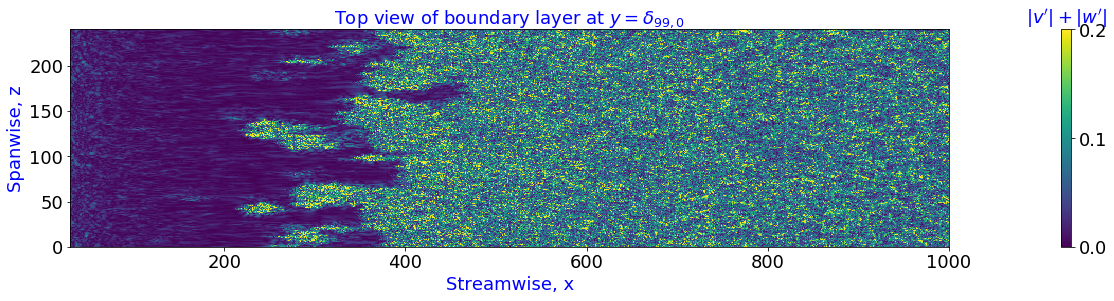

In [5]:
um=np.mean(result[:,:,0],axis=1).reshape((nix,1))
vm=np.mean(result[:,:,1],axis=1).reshape((nix,1))
up=result[:,:,0]-um
vp=result[:,:,1]-vm
wp=result[:,:,2]
f=np.abs(vp)+np.abs(wp)

fig = plt.figure(figsize = (40,4))
ax = fig.add_subplot(111)

ax.set_title('Top view of boundary layer at $ y = \delta_{99,0}$', fontsize=18, color='blue')
ax.set_xlabel('Streamwise, x', fontsize=18, color='blue')
ax.set_ylabel('Spanwise, z', fontsize=18, color='blue')
ax.tick_params(axis='both', which='major', labelsize=18)

cax = ax.imshow(f.transpose(),
               extent = [x_min, x_max, z_min, z_max],
               interpolation = 'none',
               vmin=0, vmax=0.2,
               cmap=cm.viridis)    # default colormap 'viridis', 'plasma', 'inferno', 'magma'

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[0, 0.1, 0.2], orientation='vertical')  # Horizontal/vertical  colorbar
#cbar.ax.set_yticklabels(['< -0.2', '0', '> 0.2'])  
cbar.ax.tick_params(axis='both', which='major', labelsize=18)
cbar.ax.set_title('$|v\'|+|w\'|$', fontsize=18, color='blue') 

Threshold is 0.07690154


<Figure size 2880x288 with 0 Axes>

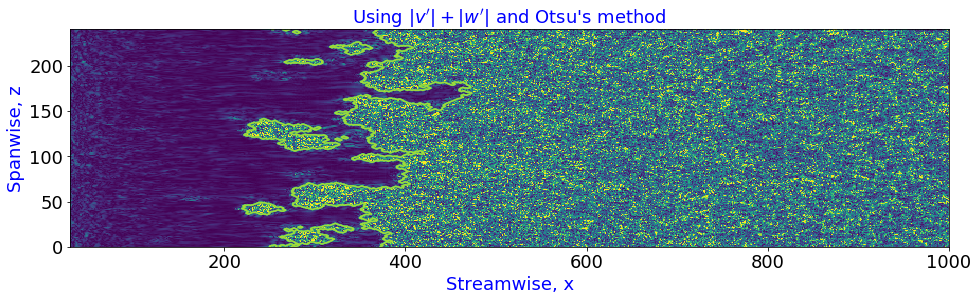

In [6]:
fig = plt.figure(figsize = (40,4))

f_th = filters.threshold_otsu(f)
print('Threshold is '+str(f_th))
mask = f > f_th
mask[-4:,:] = 1
mask = np.tile(mask,(1,3))
mask = morphology.closing(mask, morphology.disk(2))
mask = morphology.opening(mask, morphology.disk(2))
mask = ndi.binary_fill_holes(mask)
mask = mask[:,niz:2*niz]

fig = plt.figure(figsize = (40,4))
ax = fig.add_subplot(111)

ax.set_title('Using $|v\'|+|w\'|$ and Otsu\'s method', fontsize=18, color='blue')
ax.set_xlabel('Streamwise, x', fontsize=18, color='blue')
ax.set_ylabel('Spanwise, z', fontsize=18, color='blue')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_aspect(1)

cax = ax.imshow(f.transpose(),
               extent = [x_min, x_max, z_min, z_max],
               interpolation = 'none',
               vmin=0, vmax=0.2,
               cmap=cm.viridis)

ax.contour(X,Z,np.flipud(mask.transpose()))

In [7]:
um=np.mean(result[:,:,0],axis=1).reshape((nix,1))
up=result[:,:,0]-um

kmeans_input = np.zeros((result.shape[0]*result.shape[1], 12), np.float32)
#kmeans_input[:,0]=result[:,:,0].flatten()
kmeans_input[:,0]=result[:,:,1].flatten()
kmeans_input[:,1]=result[:,:,2].flatten()
#kmeans_input[:,3]=up[:,:].flatten()
kmeans_input[:,2]=vp[:,:].flatten()
for i in range(9):
    kmeans_input[:,i+3]=result_grad[:,:,i].flatten()
kmeans_input[:,-1]=points[:,:,0].flatten()

for i in range(kmeans_input.shape[1]):
    kmeans_input[:,i]=kmeans_input[:,i]/np.std(kmeans_input[:,i])

start = tt.time()
print('Machine learning training...')
kmeans = KMeans(n_clusters=2).fit(kmeans_input)
end = tt.time()
print('   '+str(end - start)+' seconds')

Machine learning training...
   7.760319948196411 seconds


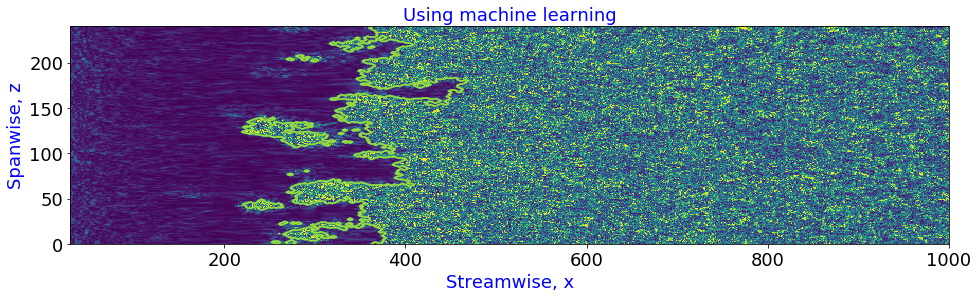

In [8]:
mask = kmeans.labels_.reshape((result.shape[0],result.shape[1]))

if (np.count_nonzero(mask[:10,:])>np.count_nonzero(~mask[:10,:])):
    mask = (mask==0)
else:
    mask = (mask==1)

mask[-4:,:] = 1
mask = np.tile(mask,(1,3))
mask = morphology.closing(mask, morphology.disk(2))
mask = morphology.opening(mask, morphology.disk(2))
mask = ndi.binary_fill_holes(mask)
mask = mask[:,niz:2*niz]

fig = plt.figure(figsize = (40,4))
ax = fig.add_subplot(111)

ax.set_title('Using machine learning', fontsize=18, color='blue')
ax.set_xlabel('Streamwise, x', fontsize=18, color='blue')
ax.set_ylabel('Spanwise, z', fontsize=18, color='blue')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_aspect(1)

cax = ax.imshow(f.transpose(),
               extent = [x_min, x_max, z_min, z_max],
               interpolation = 'none',
               vmin=0, vmax=0.2,
               cmap=cm.viridis)

ax.contour(X,Z,np.flipud(mask.transpose()))